
The goal of this notebook is to:
* generate HTM traces
* load the traces
* order by label and compute the inter-label distances
* plot the distance matrix
* run supervised classifier

# Utility functions

In [21]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
import seaborn as sns

%matplotlib inline

In [22]:
# params
SP_OUTPUT_WIDTH = 2048
TM_OUTPUT_WIDTH = 65536

In [56]:
# Helper functions
def sdr_converter(sdr_width):

    def convert_sdr(patternNZ_strings):
        patternNZs = json.loads(patternNZ_strings)
        sdrs = []
        for patternNZ in patternNZs:
            sdr = np.zeros(sdr_width)
            sdr[patternNZ] = 1
            sdrs.append(sdr.tolist())
        return np.array(sdrs)
    return convert_sdr


def load_df(file_path):
    return pd.read_csv(file_path, converters={
        'spActiveColumns': sdr_converter(SP_OUTPUT_WIDTH),
        'tmPredictedActiveCells': sdr_converter(TM_OUTPUT_WIDTH)})


def sequence_embedding(sdrs_sequence, aggregation):
    if aggregation == 'or':
        embedding = sdrs_sequence[0]
        for sdr in sdrs_sequence:
            embedding = np.logical_or(embedding, sdr)
        return embedding.astype(int)
    elif aggregation == 'and':
        embedding = sdrs_sequence[0]
        for sdr in sdrs_sequence:
            embedding = np.logical_and(embedding, sdr)
        return embedding.astype(int)
    elif aggregation == 'mean':
        return np.mean(sdrs_sequence, axis=0)
    else:
        raise ValueError('Wrong SDR aggregation name.')

        
def chunked_sequence_embedding(sdrs_sequence, aggregation, nb_chunks, flatten):
    chunk_size = len(sdrs_sequence) / nb_chunks
    embedding = []
    for i in range(nb_chunks):
        chunk = sdrs_sequence[i*chunk_size:(i+1)* chunk_size]
        embedding.append(sequence_embedding(chunk, aggregation))
    embedding = np.array(embedding)
    if flatten:
        embedding = embedding.flatten()
    return embedding


def sequence_embeddings(sdrs_sequences, aggregation, nb_chunks, flatten):
    embeddings = []
    for sdrs_sequence in sdrs_sequences:
        embedding = chunked_sequence_embedding(sdrs_sequence, aggregation, nb_chunks, flatten)
        embeddings.append(embedding)
    return embeddings


def euclidian_distance(x1, x2, nb_chunks=1):
    chunk_size = len(x1) / nb_chunks
    a = x1.reshape((nb_chunks, chunk_size))
    b = x2.reshape((nb_chunks, chunk_size))
    return mean_euclidian_distance(a, b)
    

def mean_euclidian_distance(x1, x2):
    dists = []
    for i in range(len(x1)):
        dists.append(np.linalg.norm(x2[i]-x1[i]))
    return np.mean(dists)


def distance_mats(col_embeddings, cell_embeddings, distance, cell_w=1.0, col_w=1.0):
    assert len(col_embeddings) == len(cell_embeddings)
    nb_sequences = len(col_embeddings)
    col_mat = np.zeros((nb_sequences, nb_sequences), dtype=np.float64)
    cell_mat = np.zeros((nb_sequences, nb_sequences), dtype=np.float64)
    combined_mat = np.zeros((nb_sequences, nb_sequences), dtype=np.float64)

    for i in range(nb_sequences):
        for j in range(i, nb_sequences):
            col_dist = distance(col_embeddings[i], col_embeddings[j])
            cell_dist = distance(cell_embeddings[i], cell_embeddings[j])
            col_mat[i, j] = col_dist
            cell_mat[i, j] = cell_dist
            combined_mat[i, j] = (col_w * col_dist + cell_w * cell_dist) / (col_w + cell_w)

            col_mat[j, i] = col_mat[i, j]
            cell_mat[j, i] = cell_mat[i, j]
            combined_mat[j, i] = combined_mat[i, j]
    return col_mat, cell_mat, combined_mat

def project_mat(mat):
    tsne = TSNE(n_iter=1000, metric='precomputed', init='random')
    return tsne.fit_transform(mat)


def project_embeddings(embeddings):
    tsne = TSNE(metric='euclidean', n_iter=1000, init='pca')
    flattened_embeddings = [embedding.flatten() for embedding in embeddings]
    return tsne.fit_transform(flattened_embeddings)

In [26]:
def plot_mat(embeddings_mat, embedding_name, dataset_name, aggregation):
    plt.figure(figsize=(5,4))
    heatmap = plt.pcolor(embeddings_mat, cmap=plt.cm.Blues)
    plt.colorbar(heatmap)
    plt.xlabel('Sequence #')
    plt.ylabel('Sequence #')
    plt.title('%s sequence embeddings\n'
              'Data: %s\n'
              'Aggregation: %s' % (embedding_name, dataset_name, aggregation))


def plot_projections(embeddings_proj, labels, embedding_name):

    # Colors 
    unique_labels = list(set(list(labels)))
    nb_colors = len(unique_labels)
    color_names = ['Class %s' %l for l in unique_labels]
    colors = sns.color_palette('colorblind', nb_colors) 
    
    # Plot projections
    plt.figure(figsize=(5,5))
    plt.title('%s sequence embeddings 2D projections' %embedding_name)
    plt.scatter(embeddings_proj[:,0], embeddings_proj[:,1], c=[colors[unique_labels.index(l)] for l in labels])

    # Add legend
    patches = [mpatches.Patch(color=colors[i], label=color_names[i]) for i in range(nb_colors)]
    plt.legend(handles=patches, loc=2, bbox_to_anchor=(1.05, 1)) # plot the legend to the right


def create_embeddings(df, aggregation, nb_chunks, flatten):
    sorted_df =  df.sort_values('label') # sort by label, it's easier to read this way.
    labels = df.label.values
    sp_sdrs_sequences = sorted_df.spActiveColumns.values
    tm_sdrs_sequences = sorted_df.tmPredictedActiveCells.values
    sp_embeddings = sequence_embeddings(sp_sdrs_sequences, aggregation, nb_chunks, flatten)
    tm_embeddings = sequence_embeddings(tm_sdrs_sequences, aggregation, nb_chunks, flatten)
    assert len(sp_embeddings) == len(tm_embeddings)
    return sp_embeddings, tm_embeddings


def analyze_traces(df, name, aggregations=['mean'], nb_chunks=10, flatten=False, 
                   distance=mean_euclidian_distance, tsne=True):
    labels = df.label.values
    
    for aggregation in aggregations:

        # Embeddings
        sp_embeddings, tm_embeddings = create_embeddings(df, aggregation, nb_chunks, flatten)
        
        # Distance matrices
        sp_mat, tm_mat, combined_mat = distance_mats(sp_embeddings, tm_embeddings, distance)
        
        # Plot distance matrices
        plot_mat(sp_mat, 'SP', name, aggregation)
        plot_mat(tm_mat, 'TM', name, aggregation)
        
        if tsne:
            # tSNE projections
            sp_embeddings_proj = project_mat(sp_mat)
            tm_embeddings_proj = project_mat(tm_mat)

            # Plot tSNE projections
            plot_projections(sp_embeddings_proj, labels, 'SP')
            plot_projections(tm_embeddings_proj, labels, 'TM')

In [5]:
def save_embeddings(embeddings, labels, output_file_path):
    assert len(embeddings) == len(labels)
    nb_sequences = len(embeddings)
    
    df = pd.DataFrame(data={'embedding': [json.dumps(e.tolist()) for e in embeddings], 
                            'label': labels})
    print df.head()
    df.to_csv(output_file_path)

    
def generate_and_save_embeddings(df, aggregation, nb_chunks, flatten, output_file_path):
    sp_embeddings, tm_embeddings = create_embeddings(df, aggregation, nb_chunks, flatten)
    labels = df.label.values
    save_embeddings(sp_embeddings, labels, output_file_path) 
    save_embeddings(tm_embeddings, labels, output_file_path)

# Generate HTM traces

In [6]:
# Uncomment to generate HTM traces

# import os; print 'Current working directory:', os.getcwd()
# %run network_runner_sequences.py --config configs/debug.yml
# %run network_runner_sequences.py --config configs/body_acc_x.yml
# %run network_runner_sequences.py --config configs/synthetic_control.yml
# %run network_runner_sequences.py --config configs/test1.yml

# Load datasets

In [27]:
dfs = {}

In [28]:
phase = 'TRAIN'
dfs['Test1_%s' %phase] = load_df('traces/trace_Test1_%s' %phase)

In [29]:
phase = 'TEST'
dfs['Test1_%s' %phase] = load_df('traces/trace_Test1_%s' %phase)

In [30]:
phase = 'TRAIN'
dfs['synthetic_control_%s' %phase] = load_df('traces/trace_synthetic_control_%s' %phase)

In [31]:
phase = 'TEST'
dfs['synthetic_control_%s' %phase] = load_df('traces/trace_synthetic_control_%s' %phase)

In [67]:
phase = 'TRAIN'
dfs['body_acc_x_%s' %phase] = load_df('traces/trace_body_acc_x_%s' %phase)

In [68]:
phase = 'TEST'
dfs['body_acc_x_%s' %phase] = load_df('traces/trace_body_acc_x_%s' %phase)

In [12]:
print 'datasets:', dfs.keys()

datasets: ['synthetic_control_TEST', 'Test1_TRAIN', 'Test1_TEST', 'synthetic_control_TRAIN']


# Analyze traces

### Test1

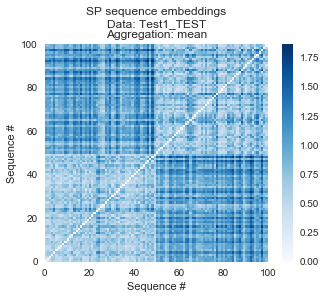

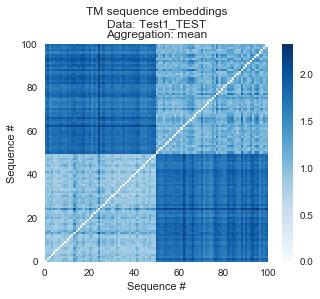

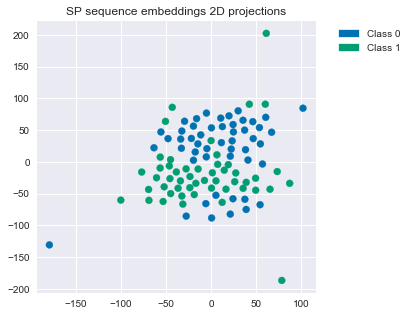

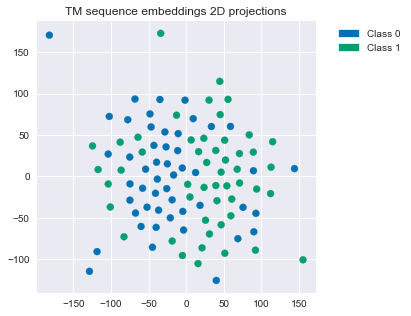

In [46]:
name = 'Test1_TEST'
nb_chunks = 1
aggregations = ['mean']

df = dfs[name]
analyze_traces(df, name, nb_chunks=nb_chunks, flatten=True, 
               distance=lambda a,b: euclidian_distance(a,b, nb_chunks=nb_chunks), 
               tsne=True, aggregations=aggregations)

### synthetic_control

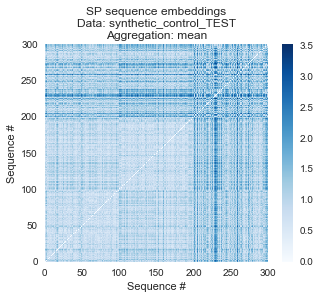

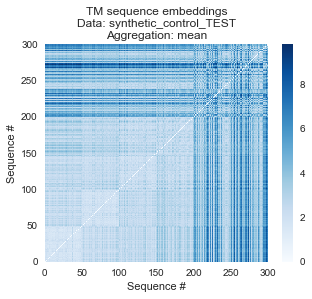

In [47]:
name = 'synthetic_control_TEST'
nb_chunks = 1
aggregations = ['mean']

df = dfs[name]
analyze_traces(df, name, nb_chunks=nb_chunks, flatten=True, 
               distance=lambda a,b: euclidian_distance(a,b, nb_chunks=nb_chunks), 
               tsne=False, aggregations=aggregations)

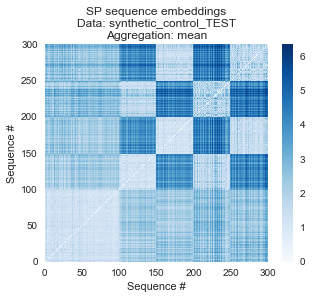

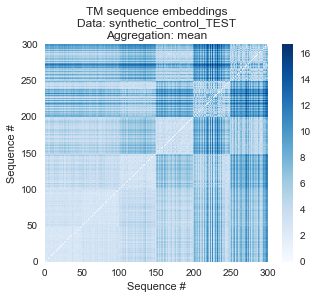

In [59]:
name = 'synthetic_control_TEST'
nb_chunks = 2
aggregations = ['mean']

df = dfs[name]
analyze_traces(df, name, nb_chunks=nb_chunks, flatten=True, 
               distance=lambda a,b: euclidian_distance(a,b, nb_chunks=nb_chunks), 
               tsne=False, aggregations=aggregations)

### body_acc_x

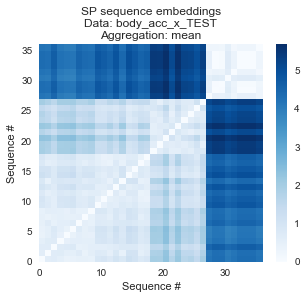

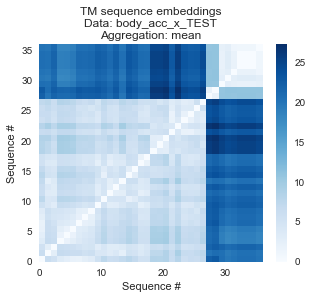

In [69]:
name = 'body_acc_x_TEST'
nb_chunks = 2
aggregations = ['mean']

df = dfs[name]
analyze_traces(df, name, nb_chunks=nb_chunks, flatten=True, 
               distance=lambda a,b: euclidian_distance(a,b, nb_chunks=nb_chunks), 
               tsne=False, aggregations=aggregations)

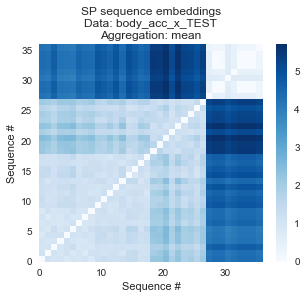

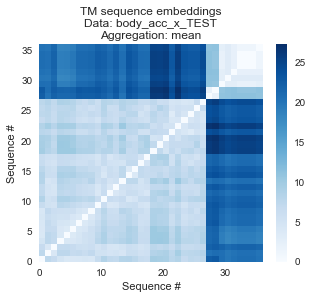

In [70]:
name = 'body_acc_x_TEST'
nb_chunks = 10
aggregations = ['mean']

df = dfs[name]
analyze_traces(df, name, nb_chunks=nb_chunks, flatten=True, 
               distance=lambda a,b: euclidian_distance(a,b, nb_chunks=nb_chunks), 
               tsne=False, aggregations=aggregations)

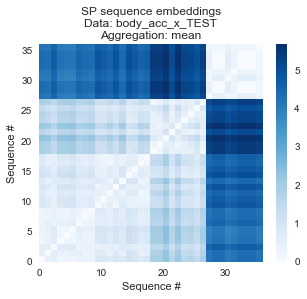

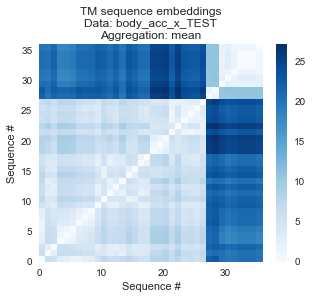

In [71]:
name = 'body_acc_x_TEST'
nb_chunks = 1
aggregations = ['mean']

df = dfs[name]
analyze_traces(df, name, nb_chunks=nb_chunks, flatten=True, 
               distance=lambda a,b: euclidian_distance(a,b, nb_chunks=nb_chunks), 
               tsne=False, aggregations=aggregations)

# Write embeddings to file

In [ ]:
name = 'Test1_TRAIN'
nb_chunks = 2
flatten = True
aggregation = 'mean'

output_file_path = '%s.csv' % name
df = dfs[name]
generate_and_save_embeddings(df, aggregation=aggregation, nb_chunks=nb_chunks, flatten=flatten,
                             output_file_path=output_file_path)

# Classification

In [49]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [60]:
def classify(dataset, nb_chunks, aggregation, cell_type, n=1):

    flatten = True
    # Classifier
    knn = KNeighborsClassifier(n_neighbors=n, algorithm='auto', 
                               metric=lambda a,b: euclidian_distance(a,b,nb_chunks=nb_chunks))

    # Train set
    name = '%s_TRAIN' % dataset
    df_train = dfs[name]
    sp_embeddings_train, tm_embeddings_train = create_embeddings(df_train, aggregation, nb_chunks, flatten)
    if cell_type == 'tm':
        X_train = np.array(tm_embeddings_train)
    elif cell_type == 'sp':
        X_train = np.array(sp_embeddings_train)
    y_train = df_train.label.values
    print 'X_train.shape:', X_train.shape
    print 'y_train.shape:', y_train.shape

    # Train
    knn.fit(X_train, y_train)

    # Test set
    name = '%s_TEST' % dataset
    df_test = dfs[name]
    sp_embeddings_test, tm_embeddings_test = create_embeddings(df_test, aggregation, nb_chunks, flatten)
    if cell_type == 'tm':
        X_test = np.array(tm_embeddings_test)
    elif cell_type == 'sp':
        X_test = np.array(sp_embeddings_test)
    y_test = df_test.label.values
    print 'X_test.shape:', X_test.shape
    print 'y_test.shape:', y_test.shape

    # Print train accuracy
    y_true = y_train
    y_pred = knn.predict(X_train)
    acc = accuracy_score(y_true, y_pred)
    print 'Train accuracy: %.2f/100' % (acc*100)
    
    # Print test accuracy
    y_true = y_test
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_true, y_pred)
    print 'Test accuracy: %.2f/100' % (acc*100)

In [63]:
dataset =  'Test1' 
nb_chunks = 2
aggregation = 'mean'
cell_type = 'sp'

classify(dataset, nb_chunks, aggregation, cell_type)

X_train.shape: (100, 4096)
y_train.shape: (100,)
X_test.shape: (100, 4096)
y_test.shape: (100,)
Train accuracy: 100.00/100
Test accuracy: 96.00/100


In [64]:
dataset =  'Test1' 
nb_chunks = 2
aggregation = 'mean'
cell_type = 'tm'

classify(dataset, nb_chunks, aggregation, cell_type)

X_train.shape: (100, 131072)
y_train.shape: (100,)
X_test.shape: (100, 131072)
y_test.shape: (100,)
Train accuracy: 100.00/100
Test accuracy: 100.00/100


In [65]:
dataset =  'synthetic_control' 
nb_chunks = 2
aggregation = 'mean'
cell_type = 'sp'

classify(dataset, nb_chunks, aggregation, cell_type)

X_train.shape: (180, 4096)
y_train.shape: (180,)
X_test.shape: (300, 4096)
y_test.shape: (300,)
Train accuracy: 100.00/100
Test accuracy: 52.33/100


In [66]:
dataset =  'synthetic_control' 
nb_chunks = 2
aggregation = 'mean'
cell_type = 'tm'

classify(dataset, nb_chunks, aggregation, cell_type)

X_train.shape: (180, 131072)
y_train.shape: (180,)
X_test.shape: (300, 131072)
y_test.shape: (300,)
Train accuracy: 100.00/100
Test accuracy: 48.00/100


In [72]:
dataset =  'body_acc_x' 
nb_chunks = 2
aggregation = 'mean'
cell_type = 'tm'

classify(dataset, nb_chunks, aggregation, cell_type)

X_train.shape: (35, 131072)
y_train.shape: (35,)
X_test.shape: (36, 131072)
y_test.shape: (36,)
Train accuracy: 97.14/100
Test accuracy: 27.78/100
